### Mia Playing Around with 2024 Bubble Data Set ###

#### Introducing the Data Set ###

In [50]:
import matplotlib.pyplot as plt
import pandas as pd


raw_df = pd.read_csv('/Users/miaaaronson/Desktop/ENE390/Thesis_Work/Data/ALL_BUBBLE_DATA_2024.csv')

# consolidating relevant data by isolating based on the title of the column
df = raw_df[
    [
        "Site",
        "X2",
        "X2.1",
        "X2.2",
        "X2.3",
        "X2.4",
    ]
]

# setting the second row (with an index of 1) as the column headers (getting rid of Legacy.XX)
df.columns = df.iloc[1]

# removing the first two rows because the first intital row (Legacy Row) is not needed and the second row is now the index row (doesnt need to be in data set)
df = df[2:].reset_index(drop=True)

# turning the column names into a list to manipulate names
column_names = df.columns.to_list()

# Assign new names to specific NaN columns by index
column_names[0] = "Time and Date"  # Rename first NaN column
column_names[3] = "pH Value"  # Rename another NaN column

# Set updated column names back to DataFrame
df.columns = column_names

# renaming the column titles to better fit with the data set
df.rename(
    columns={
        "C": "Temperature in Degrees C",
        "uS/cm": "Specific Conductivity in uS/cm",
        "%": "ODO Saturation Percentage",
        "mg/L": "ODO in mg/L",
    },
    inplace=True,
)

df = df.dropna(subset=["Temperature in Degrees C"])

df["Time and Date"] = pd.to_datetime(df["Time and Date"], format="%m-%d-%Y %H:%M:%S")
df["Temperature in Degrees C"] = pd.to_numeric(
    df["Temperature in Degrees C"], errors="coerce"
)

df['Temperature in Degrees C'] = pd.to_numeric(df['Temperature in Degrees C'], errors='coerce')

#### Plotting Raw Temperature Data ####

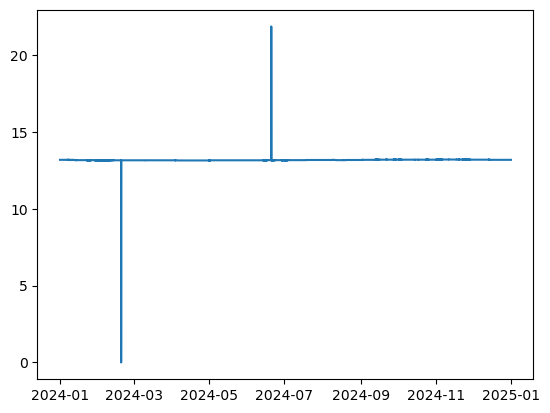

In [51]:
x = df["Time and Date"]
y = df["Temperature in Degrees C"]

plt.plot(x,y)
plt.show()

Can identify above that there are two huge outliers, somwhere around 0 and 22? We can check where these are.

In [52]:
df.describe()

,Time and Date,Temperature in Degrees C
count,35117,35117.000000
mean,2024-07-02 00:54:32.338183680,13.176622
min,2024-01-01 00:00:00,0.000000
25%,2024-04-01 13:00:00,13.160000
50%,2024-07-02 01:45:00,13.170000
75%,2024-10-01 13:15:00,13.190000
max,2024-12-31 23:45:00,21.870000
std,NaN,0.089433


Have to make sure that these values are avtually outliers and not days of extreme heat or cool. We can set a threshold and see how many are above and below. My estimation is that the outliers are above 20 and below 5. These will be our initial thresholds

In [53]:
max_threshold = 20
min_threshold = 5

count_above_threshold = (df['Temperature in Degrees C'] > max_threshold).sum()
print(f"Number of instances above {max_threshold}: {count_above_threshold}")

count_below_threshold = (df['Temperature in Degrees C'] <= min_threshold).sum()
print(f"Number of instances less than or equal to {min_threshold}: {count_below_threshold}")

Number of instances above 20: 1
Number of instances less than or equal to 5: 1


Ok, we just see one instance of each indicating that these are outliers that can be ignored. We can parse out these data points and replot.

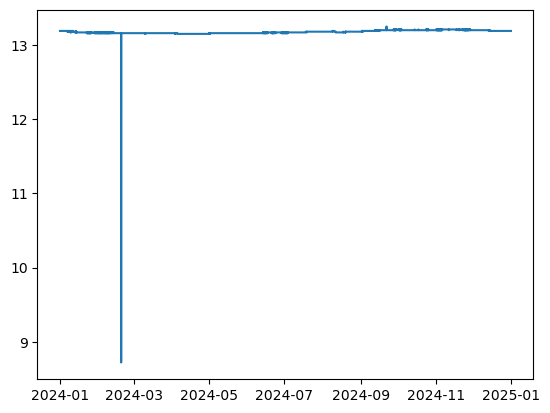

In [54]:

df = df[df["Temperature in Degrees C"] > min_threshold]
df = df[df["Temperature in Degrees C"]< max_threshold]

x = df["Time and Date"]
y = df["Temperature in Degrees C"]

plt.plot(x,y)
plt.show()

There is still one clear outlier, so we repeat the process. We do not know for sure if this is an outlier. It looks like it is below 9, so we repeat the process again.

In [55]:
min_threshold_2 = 9

count_below_threshold = (df['Temperature in Degrees C'] <= min_threshold_2).sum()
print(f"Number of instances less than or equal to {min_threshold_2}: {count_below_threshold}")

Number of instances less than or equal to 9: 1


Again, we see this is most likely an outlier, so we can eliminate it and plot again. 

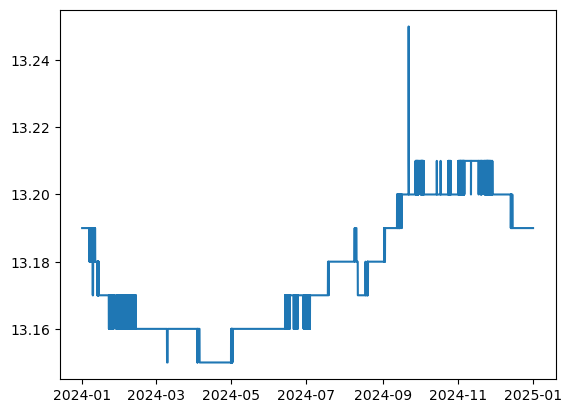

In [56]:
df = df[df["Temperature in Degrees C"] > min_threshold_2]
df = df[df["Temperature in Degrees C"]< max_threshold]

x = df["Time and Date"]
y = df["Temperature in Degrees C"]

plt.plot(x,y)
plt.show()

Cool, now we have a pretty simple grah. There is one high value that can be parsed out, but it is within the range of plausible values. This is an outlier topic to explore. Is this really an outlier? 

From here, smoothing methods can be applied to better visualize the graph. 

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


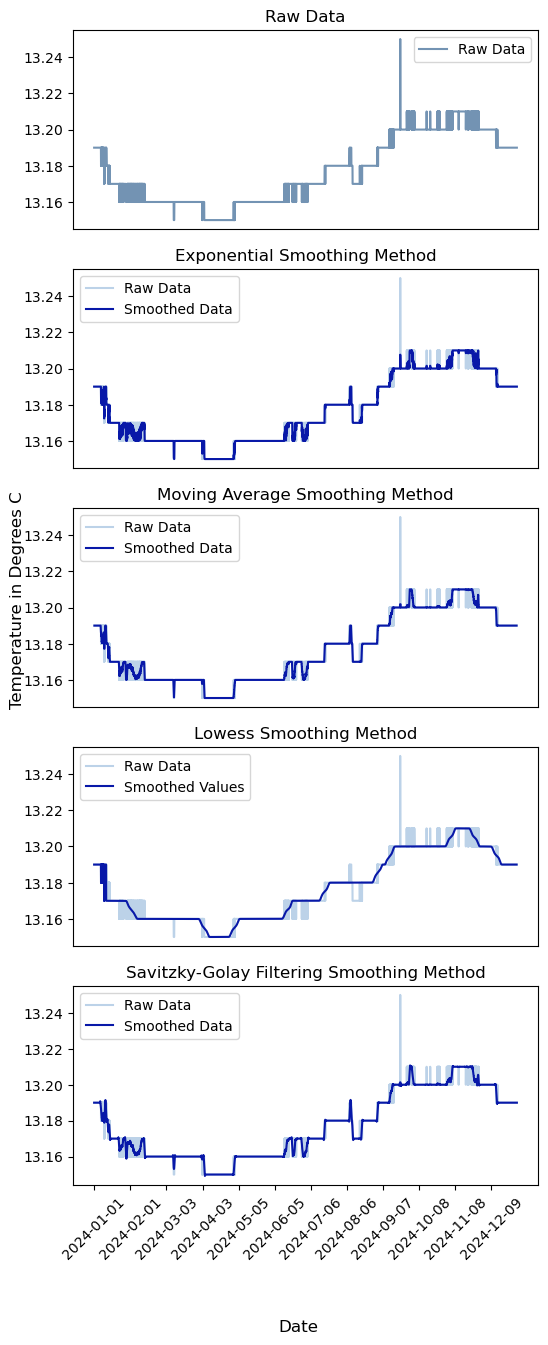

In [57]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy import signal

# exponential smoothing
exponential_smoothing_model = ExponentialSmoothing(
    y, trend=None, seasonal=None, damped_trend=False
)
fit_model = exponential_smoothing_model.fit()
y_smooth_es = fit_model.predict(
    start=len(df["Temperature in Degrees C"]), end=len(df["Temperature in Degrees C"])
)
y_smooth_es = fit_model.fittedvalues

# moving average
y_smooth_ma = y.rolling(window=50, center=True).mean()

# SGF
y_smooth_SGF = signal.savgol_filter(y, window_length=150, polyorder=3, mode="nearest")

# lowess
smoothed = lowess(df["Temperature in Degrees C"], range(len(df)), frac=0.05)

fig, axs = plt.subplots(5, 1, figsize=(6, 15))
fig.supylabel("Temperature in Degrees C", fontsize=12)  # Single large y-axis label
fig.supxlabel("Date", fontsize=12)  # Single large x-axis label
for ax in axs[:-1]:
    ax.tick_params(
        axis="x", which="both", bottom=False, top=False, labelbottom=False
    )  # Remove x-axis tick marks


# raw data graph
axs[0].plot(x, y, label="Raw Data", color="#7393B3")
axs[0].set_title("Raw Data")
axs[0].legend()

# ES graph
axs[1].plot(x, y, label="Raw Data", color="#BCD2E8")
axs[1].plot(x, y_smooth_es, label="Smoothed Data", color="#0818A8")
axs[1].set_title("Exponential Smoothing Method")
axs[1].legend()

# MS graph
axs[2].plot(x, y, label="Raw Data", color="#BCD2E8")
axs[2].plot(x, y_smooth_ma, label="Smoothed Data", color="#0818A8")
axs[2].set_title("Moving Average Smoothing Method")
axs[2].legend()

axs[3].plot(df["Temperature in Degrees C"], label="Raw Data", color="#BCD2E8")
axs[3].plot(smoothed[:, 1], label="Smoothed Values", color="#0818A8")
axs[3].set_title("Lowess Smoothing Method")
axs[3].legend()

# SGF graph
axs[4].plot(x, y, label="Raw Data", color="#BCD2E8")
axs[4].plot(x, y_smooth_SGF, label="Smoothed Data", color="#0818A8")
axs[4].set_xticks(x[::3000])
axs[4].tick_params(axis="x", rotation=45)
axs[4].set_title("Savitzky-Golay Filtering Smoothing Method")
axs[4].legend()

plt.show()

Even when we apply smoothing methods, it is clear that there is a yearly cyclic pattern happening.

Colder temperatures in the spring, incrase in the summer, height of temperatures in fall and winter time.

At this point, we can visually see some sort of pattern, but in order to really determine what is happening, we can apply the Fast-Fourier Transform (FFT).

#### Introduction to the Fast Fourier Transform #### 

The Fast Fourier Transform (FFT) is a tool that can help expose underlying patterns that are cyclic in nature within a given data set. It is particularly helpful for time series data, where parameters gathered over a year (or more) might fluxate given the time of year. It utlizies sine and cosine waves to decompose the original time series data and converts it into a frequency and amplitude set. Applying the FFT to a data set has many steps, so we will break it down.

First, we can look again at our raw data graph.

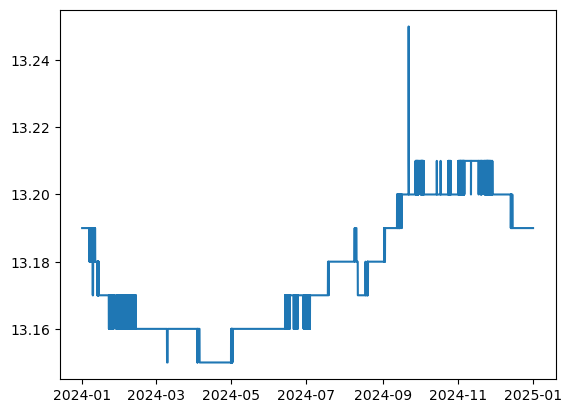

In [58]:
plt.plot(x,y)
plt.show()

First, we will apply the FFT to our temperature values (our y values)

In [59]:
import numpy as np

fft_y = np.fft.fft(y)

We have applied the FFT to our data set! We can confirm this by using Parseval's theorem. 

Parseval's theorem states that the square of a time series inegreated over time is equal to the square of the FFT integrated over frequency!

In [60]:
v_fft_y = fft_y/len(y)

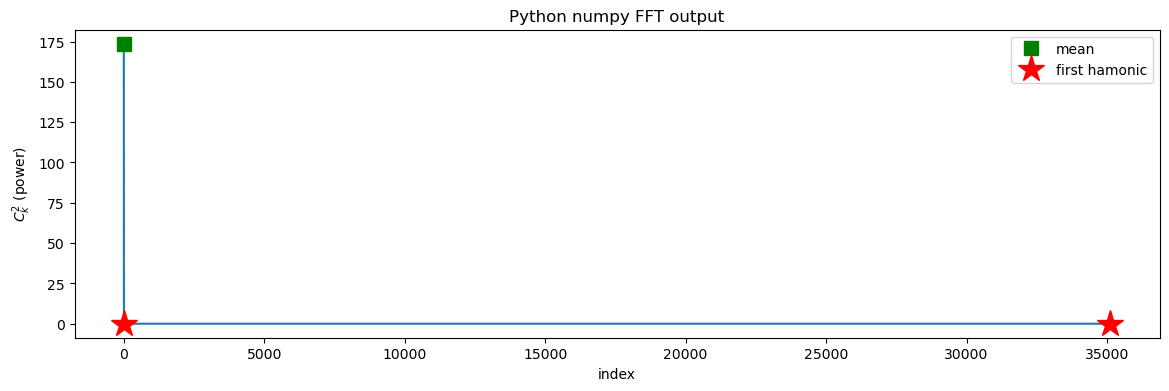

In [61]:
plt.figure (figsize = (14,4))


# plot blue line
plt.plot(np.arange(0, np.size(v_fft_y)),np.abs(v_fft_y)**2)

# plot markers
plt.plot(0,np.abs(v_fft_y[0])**2.,'sg',markersize=10,label='mean')
plt.plot(1,np.abs(v_fft_y[1])**2.,'*r',markersize=20,label='first hamonic')
plt.plot(np.size(v_fft_y)-1,np.abs(v_fft_y[-1])**2.,'*r',markersize=20)

plt.xlabel('index')
plt.ylabel('$C_k^2$ (power)')

plt.title('Python numpy FFT output')
plt.legend()

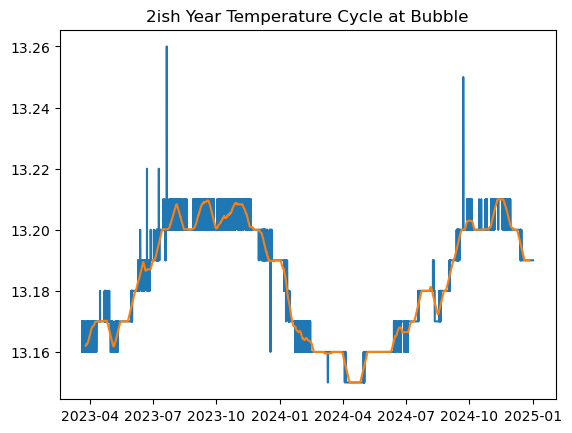

In [83]:
from statsmodels.nonparametric.smoothers_lowess import lowess

raw_df_2024 = pd.read_csv('/Users/miaaaronson/Desktop/ENE390/Thesis_Work/Data/ALL_BUBBLE_DATA_2024.csv')
raw_df_2023 = pd.read_csv('/Users/miaaaronson/Desktop/ENE390/Thesis_Work/Data/ALL_BUBBLE_DATA_2023.csv')

def clean_water_data(raw_df):
    # Consolidate relevant data by selecting specific columns
    df = raw_df[
        [
            "Site",
            "X2",
            "X2.1",
            "X2.2",
            "X2.3",
            "X2.4",
        ]
    ]
    
    # Set the second row as column headers
    df.columns = df.iloc[1]
    
    # Remove the first two rows and reset index
    df = df[2:].reset_index(drop=True)
    
    # Convert column names to a list for manipulation
    column_names = df.columns.to_list()
    
    # Rename specific NaN columns
    column_names[0] = "Time and Date"
    column_names[3] = "pH Value"
    
    # Set updated column names back to DataFrame
    df.columns = column_names
    
    # Rename other columns for clarity
    df.rename(
        columns={
            "C": "Temperature (C)",
            "uS/cm": "Specific Conductivity (uS/cm)",
            "%": "ODO (Saturation)",
            "mg/L": "ODO (mg/L)",
        },
        inplace=True,
    )
    
    # Drop rows where Temperature in Degrees C is NaN
    df = df.dropna(subset=["Temperature (C)"])
    
    # Convert columns to appropriate data types
    df["Time and Date"] = pd.to_datetime(df["Time and Date"], format="%m-%d-%Y %H:%M:%S")
    df["Temperature (C)"] = pd.to_numeric(df["Temperature (C)"], errors="coerce")
    
    return df

final_2024 = clean_water_data(raw_df_2024)
final_2023 = clean_water_data(raw_df_2023)

all_data = pd.concat([final_2023, final_2024])


max_threshold = 13.3
min_threshold = 10

all_data = all_data[all_data["Temperature (C)"] > min_threshold]
all_data = all_data[all_data["Temperature (C)"]< max_threshold]

x_total = all_data['Time and Date']
y_total = all_data['Temperature (C)']

y_total_smoothed = y_total.rolling(window=1000, center=True).mean()

plt.plot(x_total, y_total)
plt.plot(x_total, y_total_smoothed)
plt.title('2ish Year Temperature Cycle at Bubble')
plt.show()

In [91]:
import numpy as np
import matplotlib.pyplot as plt

# Compute time differences in seconds
all_data['Timestamp'] = pd.to_datetime(all_data['Time and Date'])  # Ensure correct datetime format
time_diffs = np.diff(df['Timestamp']).astype('timedelta64[s]').astype(float)

# Compute average sampling interval
sampling_interval = np.mean(time_diffs)  # seconds per sample
sampling_rate = 1 / sampling_interval  # Hz

# Apply FFT with zero-padding for finer resolution
N = len(y_total) * 10  # Use original data (or y_total_smoothed if preferred)
fft_values = np.fft.fft(y_total, n=N)

# Compute frequencies
frequencies = np.fft.fftfreq(N, d=sampling_interval)

# Plot FFT Spectrum (Magnitude)
plt.figure(figsize=(10, 5))
plt.bar(frequencies[:N//2], np.abs(fft_values[:N//2]))  # Only positive frequencies
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.title("FFT of Temperature Data at Bubble")
plt.yscale("log")  # Log scale helps reveal smaller frequencies
plt.show()

